# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt
import matplotlib.patches as mpatches
from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn import preprocessing


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict



pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3981, 822)

In [5]:
mp3_fpa_df_unique['I_Q_kA'] = mp3_fpa_df_unique["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
mp3_fpa_df_unique['dI_dt_from_data_round'] = mp3_fpa_df_unique["dI_dt_from_data"].apply(lambda x: int(np.round(x)))

mp3_fpa_df_unique['datetime'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)'])
mp3_fpa_df_unique['year'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.year)
mp3_fpa_df_unique['month'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.month)
mp3_fpa_df_unique['day'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.day)

# Read metadata

In [6]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Short magnet ID,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,3288,14.0,3.0,01B,02B8,11488.0,NaN,NaN,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,2256,14.0,2.0,01E,02C0,10622.0,NaN,NaN,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,2330,14.0,2.0,01E,02C9,12427.0,NaN,NaN,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,2319,14.0,2.0,01E,02C9,11155.0,NaN,NaN,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,1296,14.0,1.0,01E,02B8,11782.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,3123,14.0,3.0,01B,02G,12645.0,NaN,NaN,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,1062,14.0,1.0,01B,02B5,12379.0,NaN,NaN,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,2061,14.0,2.0,01B,02K,11757.0,NaN,NaN,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,3172,14.0,3.0,01B,02G,11656.0,NaN,NaN,0,0


In [7]:
mp3_fpa_df_unique = mp3_fpa_df_unique.merge(rb_magnet_metadata,
                                            left_on=["Magnet"],
                                            right_on=["Magnet"],
                                            how="left", suffixes=('', '_y'))

drop_columns = mp3_fpa_df_unique.filter(regex='Unnamed').columns.to_list()
drop_columns += mp3_fpa_df_unique.filter(regex='_y').columns.to_list()
mp3_fpa_df_unique = mp3_fpa_df_unique.drop(columns=drop_columns)

# Generate Feature Vector

In [8]:
event_features = {
    # Circuit
    'Circuit': {'dtype': str, 'ftype': 'event', 'one_hot': True}, 
    # Event Times
    'timestamp_fgc': {'dtype': int, 'ftype': 'event', 'one_hot': False}, 
    'Delta_t(FGC-PIC)': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'Delta_t(EE_even-PIC)': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'Delta_t(EE_odd-PIC)': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'Delta_t(iQPS-PIC)': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'Delta_t(nQPS-PIC)': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'Plateau duration': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    't_EE_odd': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    't_EE_even': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'I_end_2_from_data': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    # Event Measurements
    'I_Q_circ': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'I_Q_M': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'I_Earth_max': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'MIITS_circ': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'U_EE_max_ODD': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'U_EE_max_EVEN': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'dU_iQPS/dt': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'V_symm_max': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'dV_symm/dt':{'dtype': float, 'ftype': 'event', 'one_hot': False},
    'R_DL_max': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'I at R_DL_max': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'dI_Q_Acc': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'dI_Q_LHC': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'R_EE_odd': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    'R_EE_even': {'dtype': float, 'ftype': 'event', 'one_hot': False},
    # Event Context, how to add quench position                
    'FPA Reason': {'dtype': str, 'ftype': 'event', 'one_hot': True},
    'Type of Quench': {'dtype': str, 'ftype': 'event', 'one_hot': True},
    'Quench origin': {'dtype': str, 'ftype': 'event', 'one_hot': True},
    'QDS trigger origin': {'dtype': str, 'ftype': 'event', 'one_hot': True},
    'Quench count': {'dtype': float, 'ftype': 'event', 'one_hot': False},
}

position_features = {
    # Position feature
    'El. Position': {'dtype': int, 'ftype': 'position', 'one_hot': False},
    'Phys. Position': {'dtype': int, 'ftype': 'position', 'one_hot': False},
    # Position Measurement
    'I_Q_SM18': {'dtype': float, 'ftype': 'position', 'one_hot': False},
    'R_1': {'dtype': float, 'ftype': 'position', 'one_hot': False},
    'R_2': {'dtype': float, 'ftype': 'position', 'one_hot': False}, 
    'RRR_1': {'dtype': float, 'ftype': 'position', 'one_hot': False}, 
    'RRR_2': {'dtype': float, 'ftype': 'position', 'one_hot': False},
    # Position Context
    'Manufacturer': {'dtype': str, 'ftype': 'position', 'one_hot': True},
    'Inner cable type': {'dtype': str, 'ftype': 'position', 'one_hot': True},
    'Outer cable type': {'dtype': str, 'ftype': 'position', 'one_hot': True},
    'B1_aperture': {'dtype': str, 'ftype': 'position', 'one_hot': True}, 
    'Diode_type': {'dtype': str, 'ftype': 'position', 'one_hot': True}, 
    'Correctors': {'dtype': str, 'ftype': 'position', 'one_hot': True}, 
    'EE place': {'dtype': str, 'ftype': 'position', 'one_hot': True},
    'QPS Crate Number': {'dtype': float, 'ftype': 'position', 'one_hot': True},
    'Cryostat Number': {'dtype': float, 'ftype': 'position', 'one_hot': True},
    'Num of splices': {'dtype': float, 'ftype': 'position', 'one_hot': False},
    'age': {'dtype': float, 'ftype': 'position', 'one_hot': False}
}

df_feature_context = pd.concat([pd.DataFrame(event_features).T, pd.DataFrame(position_features).T])
df_feature_context['nunique'] = mp3_fpa_df_unique[df_feature_context.index.values].nunique()

len(event_features), len(position_features)

(31, 18)

In [9]:
df_feature_context[df_feature_context.ftype=='position'][['one_hot','nunique']]

,one_hot,nunique
El. Position,False,152
Phys. Position,False,154
I_Q_SM18,False,528
R_1,False,75
R_2,False,76
RRR_1,False,82
RRR_2,False,83
Manufacturer,True,3
Inner cable type,True,3
Outer cable type,True,9


In [10]:
df_feature_context[df_feature_context.ftype=='position'].T.add_suffix('_q').T[['one_hot','nunique']]

,one_hot,nunique
El. Position_q,False,152
Phys. Position_q,False,154
I_Q_SM18_q,False,528
R_1_q,False,75
R_2_q,False,76
RRR_1_q,False,82
RRR_2_q,False,83
Manufacturer_q,True,3
Inner cable type_q,True,3
Outer cable type_q,True,9


In [11]:
df_feature_context[df_feature_context.ftype=='event'][['one_hot','nunique']]

,one_hot,nunique
Circuit,True,8
timestamp_fgc,False,822
Delta_t(FGC-PIC),False,29
Delta_t(EE_even-PIC),False,37
Delta_t(EE_odd-PIC),False,48
Delta_t(iQPS-PIC),False,37
Delta_t(nQPS-PIC),False,48
Plateau duration,False,70
t_EE_odd,False,48
t_EE_even,False,37


# Load Data

In [12]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])

data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

## Define training data

In [13]:
# all events with successfully loaded data
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)] 

# model is not trained on data before 2021 and events with fast secondary quenches
bool_R2 =  (mp3_fpa_df['timestamp_fgc'] < 1611836512820000000)
bool_fast = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) & (mp3_fpa_df['Nr in Q event'].astype(str) !='1')) 
bool_test = bool_R2 | bool_fast
            
fpa_identifiers_test = fpa_identifiers[np.isin(fpa_identifiers, mp3_fpa_df[bool_test].fpa_identifier.unique())]

bool_train = ~np.isin(fpa_identifiers, fpa_identifiers_test)
fpa_identifiers_train = fpa_identifiers[bool_train]
print(len(fpa_identifiers_train), len(fpa_identifiers_test))

# add dims for indexing flattended data
bool_train_1EE = np.stack([bool_train for l in range(data_1EE_ff_scaled.shape[1])]).T.reshape(-1)
bool_train_2EE = np.stack([bool_train for l in range(data_2EE_ff_scaled.shape[1])]).T.reshape(-1)

425 135


# <h1><center><font size="30">Non-negative components - NMF</font></center></h1>

<h1><font size="8">1st Energy Extraction Plateau</font></h1>

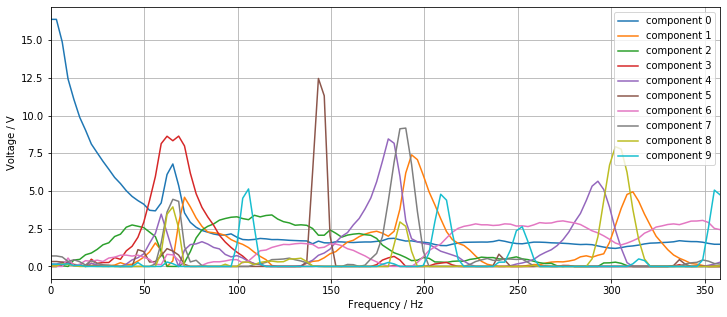

In [14]:
hyperparameter = {
    "n_components": 10,
    "solver": "cd",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-3,
    "max_iter": 200,
    "l1_ratio": 0.5,
    "alpha": 1,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=data_1EE[bool_train_1EE])
W_1EE = nmf_model.transform(X=data_1EE)
H_1EE = nmf_model.components_

plot_nmf_components(H_1EE, dataset_1EE_fft)

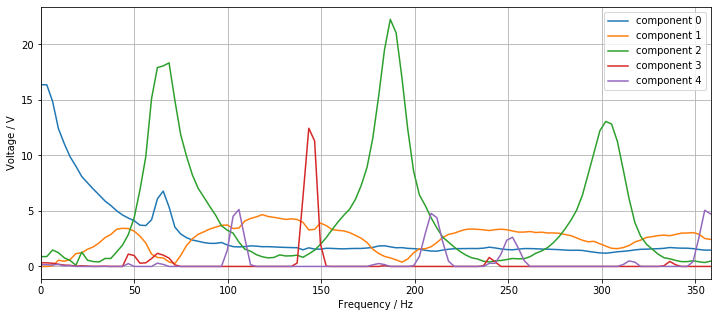

In [15]:
merge_component_index = [0, [2, 6], [1, 3, 4, 7, 8], 5, 9] #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #
H_1EE_merged = merge_array(H_1EE.T, merge_component_index, axis=-1, func=np.sum).T
W_1EE_merged = merge_array(W_1EE, merge_component_index, axis=-1, func=np.mean)

H_1EE_processed, component_weights_1EE = nmf_model.normalize_H(H=H_1EE_merged, W=W_1EE_merged)
plot_nmf_components(H_1EE_merged, dataset_1EE_fft)

## Check components

In [16]:
use_fpa_identifier = True
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A78_1617170255140000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(47, 'RB_RB.A78_1617170255140000000', '2021-03-31 07:57:35.120000')

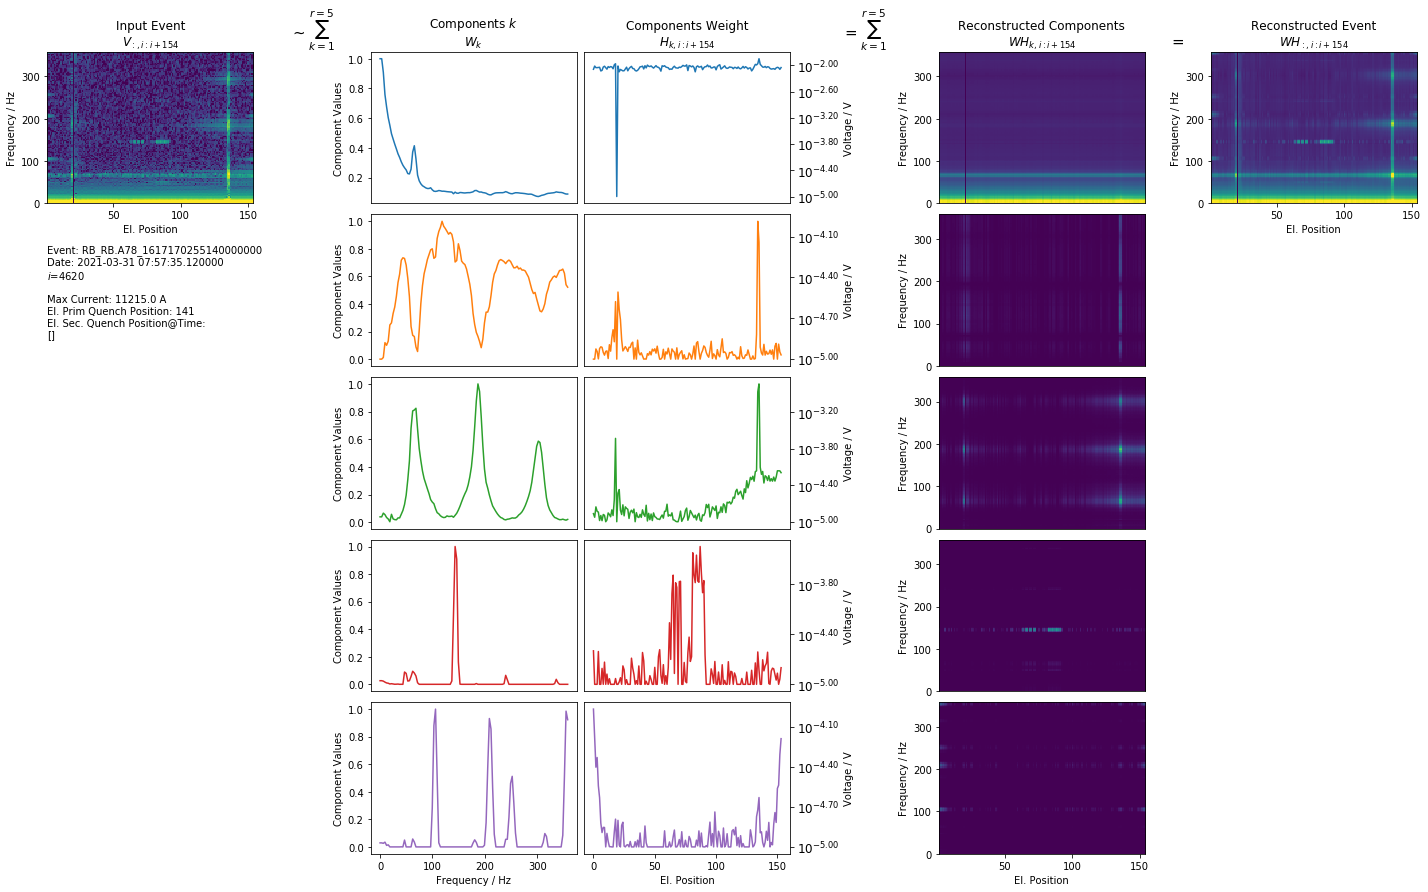

In [17]:
component_indexes_1EE = [0, 1, 2, 3, 4] 
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

## Calculate correlation matix event context

In [18]:
#define event and position data
df_event = mp3_fpa_df_unique.loc[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers), df_feature_context[(df_feature_context.ftype=='event')].index.values]
df_position = rb_magnet_metadata[df_feature_context[(df_feature_context.ftype=='position')].index.values]

#process event data
one_hot_columns = df_feature_context[(df_feature_context.ftype=='event') & (df_feature_context.one_hot==True)].index.values
df_event_processed = pd.get_dummies(df_event, columns=one_hot_columns)
scale_columns = df_feature_context[(df_feature_context.ftype=='event') &(df_feature_context.one_hot==False)].index.values
df_event_processed[scale_columns] = ((df_event[scale_columns] - df_event[scale_columns].mean()) / df_event[scale_columns].std())[scale_columns]

#process position data
one_hot_columns = df_feature_context[(df_feature_context.ftype=='position') & (df_feature_context.one_hot==True)].index.values
df_position_processed  = pd.get_dummies(df_position, columns=one_hot_columns)
scale_columns = df_feature_context[(df_feature_context.ftype=='position') & (df_feature_context.one_hot==False)].index.values
df_position_processed[scale_columns] = ((df_position[scale_columns] - df_position[scale_columns].mean()) / df_position[scale_columns].std())[scale_columns]

In [19]:
n_events = len(fpa_identifiers)
n_magnets = 154
n_features = df_event_processed.shape[-1] + 2*df_position_processed.shape[-1] + 2
data = np.zeros((n_events, n_magnets, n_features))

for i, f in enumerate(fpa_identifiers):
    circuit = f.split('_')[1]
    timestamp_fgc = int(f.split('_')[2])
    quenched_magnet = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier ==f].Magnet.values[0]
    
    df_event_data = df_event_processed[df_event.timestamp_fgc==timestamp_fgc]
    df_q_pos_data = df_position_processed[(rb_magnet_metadata.Circuit==circuit) & (rb_magnet_metadata.Magnet == quenched_magnet)].add_suffix('_q')
    for j, m in enumerate(rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].Magnet):
        df_pos_data = df_position_processed[(rb_magnet_metadata.Circuit==circuit) & (rb_magnet_metadata.Magnet == m)]
        
        df_pos_data['El. Dist. to Quench'] = df_pos_data['El. Position'].values - df_q_pos_data['El. Position_q'].values
        df_pos_data['Phys. Dist. to Quench'] = df_pos_data['Phys. Position'].values - df_q_pos_data['Phys. Position_q'].values
        
        df_data = pd.concat([df_event_data.reset_index(drop=True), df_q_pos_data.reset_index(drop=True), df_pos_data.reset_index(drop=True)], axis=1)
        data[i, j] = df_data.fillna(0).values

# Train NN

In [20]:
from tensorflow import keras
import tensorflow as tf

In [21]:
X = np.nan_to_num(data.reshape(-1, n_features))
y = (component_weights_1EE - component_weights_1EE.mean(axis=0)) / component_weights_1EE.std(axis=0)

X_train = np.nan_to_num(data.reshape(-1, n_features))[bool_train_1EE]
y_train = (component_weights_1EE[bool_train_1EE] - component_weights_1EE[bool_train_1EE].mean(axis=0)) / component_weights_1EE[bool_train_1EE].std(axis=0)

X_test = np.nan_to_num(data.reshape(-1, n_features))[~bool_train_1EE]
y_test = (component_weights_1EE[~bool_train_1EE] - component_weights_1EE[~bool_train_1EE].mean(axis=0)) / component_weights_1EE[~bool_train_1EE].std(axis=0)

In [22]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(154*8,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(5))
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, epochs=100)

model.summary()
y_pred = model.predict(X_train)
model.save('')

Epoch 1/100
2046/2046 [==============================] - 5s 3ms/step - loss: 0.7988
Epoch 2/100
2046/2046 [==============================] - 5s 3ms/step - loss: 0.6539
Epoch 3/100
2046/2046 [==============================] - 5s 3ms/step - loss: 0.5951
Epoch 4/100
2046/2046 [==============================] - 6s 3ms/step - loss: 0.5658
Epoch 5/100
2046/2046 [==============================] - 5s 2ms/step - loss: 0.5487
Epoch 6/100
2046/2046 [==============================] - 6s 3ms/step - loss: 0.5363
Epoch 7/100
2046/2046 [==============================] - 5s 2ms/step - loss: 0.5279
Epoch 8/100
2046/2046 [==============================] - 5s 2ms/step - loss: 0.5206
Epoch 9/100
2046/2046 [==============================] - 4s 2ms/step - loss: 0.5152
Epoch 10/100
2046/2046 [==============================] - 4s 2ms/step - loss: 0.5096
Epoch 11/100
2046/2046 [==============================] - 5s 2ms/step - loss: 0.5039
Epoch 12/100
2046/2046 [==============================] - 5s 2ms/step - lo

2046/2046 [==============================] - 5s 3ms/step - loss: 0.3894
Epoch 98/100
2046/2046 [==============================] - 4s 2ms/step - loss: 0.3887
Epoch 99/100
2046/2046 [==============================] - 4s 2ms/step - loss: 0.3899
Epoch 100/100
2046/2046 [==============================] - 5s 3ms/step - loss: 0.3864
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1232)              151536    
_________________________________________________________________
dropout (Dropout)            (None, 1232)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6165      
Total params: 157,701
Trainable params: 157,701
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
This property should not 

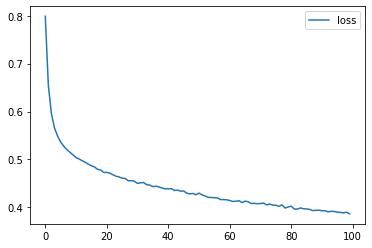

In [23]:
pd.DataFrame(history.history).plot()

In [24]:
model = tf.keras.models.load_model('')
model.evaluate(X_train)
model.evaluate(X_test)
y_pred = model.predict(X_train)

650/650 [==============================] - 0s 603us/step - loss: 0.0000e+00


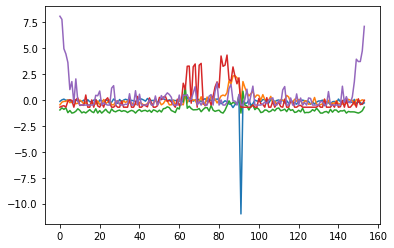

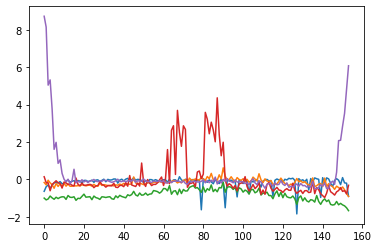

In [25]:
plt.plot(y_train[0:154])
plt.figure()
plt.plot(y_pred[0:154])
plt.show()

# Explainable AI

In [26]:
import shap
from shap.explainers._gradient import Gradient

In [27]:
background_size = 10
background = X_train[np.random.choice(X_train.shape[0], background_size, replace=False)]
explain_size = 100
X_explain = X_train[np.random.choice(X_train.shape[0], explain_size, replace=False)]

explainer = shap.GradientExplainer(model, background)

Using TensorFlow backend.


In [28]:
sample_importance = explainer.shap_values(X_explain)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [29]:
importance_mean = np.mean(np.abs(sample_importance), axis=1)

importance_sorted = np.sort(importance_mean, axis=-1)[:, ::-1]
sorted_columns = np.argsort(importance_mean, axis=-1)[:, ::-1]

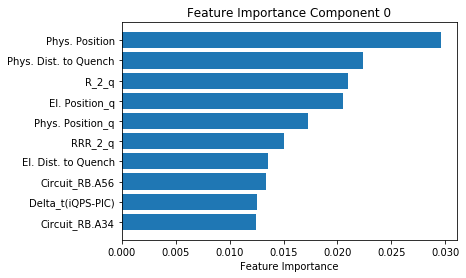

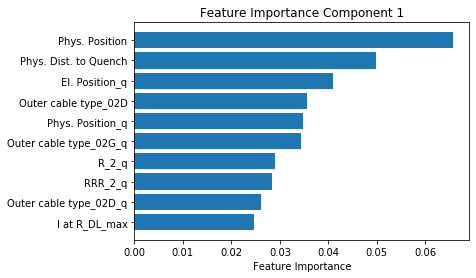

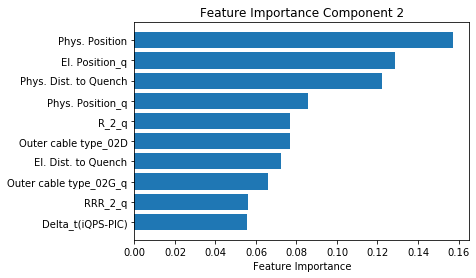

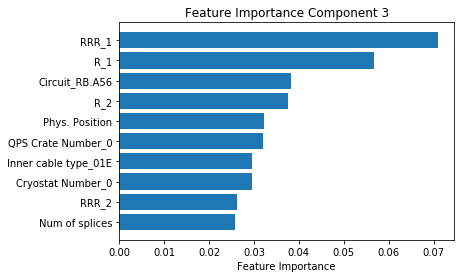

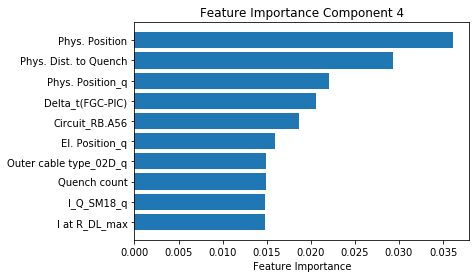

In [30]:
for component in range(len(importance_mean)):
    plt.figure()
    plt.barh(df_data.columns.values[sorted_columns][component, :10][::-1], importance_sorted[component,:10][::-1])
    plt.title(f"Feature Importance Component {component}")
    plt.xlabel('Feature Importance')